# Testing GT catalogue load

Objectives:
1. Test GT simulation waveform polarizations generated through nrc-catalogue-tools against lal.
1. Compare nrcat, wftools, lal  waveform polarizations.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows:

1. [Step 1](#initialize): Initialize needed Python modules
1. [Step 2](#extrinsic_params): Initialize the extrinsic parameters of the source
1. [Step 3, Method I](#nrcat_waveform): Generate the observer polarizations using nrcatalogtools
1. [Step 4, Method II](#lal_waveform): Generate the observer polarizations using lalsimulation through pycbc
1. [Step 5, Method III](#wftools_waveform): Generate the observer polarizations using waveformtools.
1. [Step 6](#comparisons): Test modes. Load lal modes and compare with others. This includes:
    1. [Step 6.1](#mismatch): Mismatches
    1. [Step 6.2](#pointwise): Pointwise comparison.
   

<a id='initialize'></a>

# Step 1: Initialize needed Python modules [Back to [top](#toc)\]
$$\label{initialize}$$


## Display the environment

In [1]:
%%bash
python --version
conda info --envs | grep '*'

Python 3.10.11
nrcat                 *  /home/vaishakp/Softwares/anaconda3/envs/nrcat


## Basic imports

In [1]:
import sys
import numpy as np
import h5py

### Ensure h5f5 write access

In [2]:
%%bash
export HDF5_USE_FILE_LOCKING=FALSE

In [2]:
import os

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
os.putenv("HDF5_USE_FILE_LOCKING", "FALSE")

## nrcatalogtools imports

In [3]:
# libpath = "/home/vaishakp/Codes/custom_libraries/nr-catalog-tools-vp/"
# libpath = '/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/nr-catalog-tools'
# libpath = '/home/vaishakprasad/Documents/Codes/nr-catalog-tools-vp'
# libpath = '/home/vprasad/Documents/Projects/nr-catalog-tools-vp'
# lalpath = '/home/vaishakprasad/soft/lalsuite-dev/lib/python3.11/site-packages'
# lalpath = '/home/vaishakprasad/soft/lalsuite-dev/lib/python3.11/site-packages'

# if libpath not in sys.path:
#     sys.path.append(libpath)

# if lalpath not in sys.path:
#    sys.path = [lalpath] + sys.path

print(sys.path)
import nrcatalogtools

print(nrcatalogtools.__file__)

# import nrcatalogtools.lvc as lalutils
# from nrcatalogtools import utils
# from nrcatalogtools.lvc import get_lal_mode_dictionary_from_lmax
from nrcatalogtools.maya import MayaCatalog
from nrcatalogtools.utils import maya_catalog_info

['/home/prayush/src/nr-catalog-tools/notebooks', '/home/prayush/src/pysurrogate', '/home/prayush/src/nr-catalog-tools/notebooks', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python310.zip', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/lib-dynload', '', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/site-packages', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/site-packages/nrcatalogtools-0.0.1-py3.10.egg']
lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work
No version information file '.version' found
/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/site-packages/nrcatalogtools-0.0.1-py3.10.egg/nrcatalogtools/__init__.py


### Apply lal convention to nrcat waveforms

In [4]:
nrcat_use_lal_conven = True

## Ensure lal paths

In [6]:
%%bash 
export LAL_DATA_PATH="/home/vaishakp/Softwares/lalsuite-extra/data/lalsimulation"

In [5]:
%%bash
echo $LAL_DATA_PATH

/media/prayush/Data/src/lalsuite-extra/data/lalsimulation/


In [6]:
import lal

print(lal.__file__)

/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/site-packages/lal/__init__.py


### Ensure SEOBNRv4_ROM

In [7]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants that are available
# print(td_approximants())

apx = "SEOBNRv4_ROM"
if apx not in td_approximants():
    # print('Apx not loaded correctly!')
    raise AttributeError(f"Approximant {apx} not found! Please check `LAL_DATA_PATH`")
# List of fd approximants that are currently available
# print(fd_approximants())

### Set lal phi_ref brhavior

In [8]:
lal_use_coa_phase_as_phi_ref = False

## pycbc imports

In [9]:
from pycbc import pnutils
from pycbc.filter.matchedfilter import match
from pycbc.types.timeseries import TimeSeries
from pycbc.waveform.utils import coalign_waveforms

## Waveformtools imports

In [11]:
from waveformtools.waveforms import modes_array
from waveformtools.waveformtools import roll, xtract_camp_phase, match_wfs

## Plotting

In [12]:
import matplotlib.pyplot as plt


#####################
# matplotlib presets
#####################

labelsize = 16
labelpad = 14

plt.rcParams.update({"font.size": 12})
plt.rcParams.update({"figure.figsize": (8, 6)})
# plt.rcParams.update({"axes.grid" : True})
plt.rcParams.update({"axes.labelpad": labelpad})
plt.rcParams.update({"axes.labelsize": labelsize})
plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"grid.alpha": 0.3})
plt.rcParams.update({"grid.alpha": 0.3})
plt.rcParams.update({"legend.markerscale": 12})

<a id='extrinsic_params'></a>

# Step 1: Initialize the extrinsic parameters of the source [Back to [top](#toc)\]
$$\label{extrinsic_params}$$


In [13]:
mc = MayaCatalog.load(verbosity=1, download=True)

68.7kB [00:00, 15.5MB/s]                 


In [24]:
lengths = []
for sim_id in mc.simulations:
    print(sim_id)
    xx = mc.get(sim_id).get_td_waveform(100, 1, 0, 0, delta_t=1.0 / 2048)
    lengths.append(len(xx))
    # plt.plot(xx)

GT0001
Computing reference time..
Reference time not found in waveform h5 file.
Reference time not found in simulation metadata file.
Reference time should be computed fromthe reference orbital frequency!
Reference orbital phase not found in simulation metadata.Proceeding to retrieve from the h5 file.. 'Omega'
No interpolation required.
GT0002
Computing reference time..
Reference time not found in waveform h5 file.
Reference time not found in simulation metadata file.
Reference time should be computed fromthe reference orbital frequency!
Reference orbital phase not found in simulation metadata.Proceeding to retrieve from the h5 file.. 'Omega'
No interpolation required.
GT0003
Computing reference time..
Reference time not found in waveform h5 file.
Reference time not found in simulation metadata file.
Reference time should be computed fromthe reference orbital frequency!
Reference orbital phase not found in simulation metadata.Proceeding to retrieve from the h5 file.. 'Omega'
No interpo

KeyError: "Unable to synchronously open object (object 'X' doesn't exist)"

In [29]:
list(mc.simulations.keys())[51]

'GT0356'

In [102]:
sim_name = "GT0356"

# Parameters
M = 40
D = 1000
inc = np.pi / 2 - 0.01
# np.pi/3 - 0.0001
coa_phase = np.pi / 6
# coa_phase0 = np.pi/6
delta_t = 1.0 / (4 * 2048) / 2

<a id='nrcat_waveform'></a>

# Method I : through nr-catalog-tools [Back to [top](#toc)\]
$$\label{nrcat_waveform}$$

## GT cat details

In [103]:
nrcatalogtools.utils.maya_catalog_info

{'cache_dir': PosixPath('/home/prayush/.cache/MAYA'),
 'url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files',
 'metadata_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/catalog-table.txt',
 'data_dir': PosixPath('/home/prayush/.cache/MAYA/data'),
 'metadata_dir': PosixPath('/home/prayush/.cache/MAYA/metadata'),
 'data_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files'}

## Load waveform

Computing reference time..
Reference time not found in waveform h5 file.
Reference time not found in simulation metadata file.
Reference time should be computed fromthe reference orbital frequency!
Reference orbital phase not found in simulation metadata.Proceeding to retrieve from the h5 file.. 'Omega'
No interpolation required.


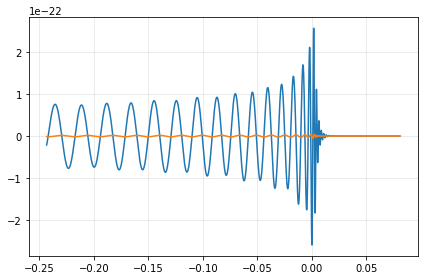

In [104]:
# sc = sxs.Catalog.load(download=True)
# rc = RITCatalog.load(verbosity=5, download=True)
mc = MayaCatalog.load(verbosity=1, download=True)

mwf1 = mc.get(sim_name)

hpc = mwf1.get_td_waveform(
    total_mass=M, distance=D, inclination=inc, coa_phase=coa_phase, delta_t=delta_t
)
hpc_pycbc = hpc  # mwf.to_pycbc(hpc)

# Minus sign to rotate by pi/2
hp_n, hx_n = hpc_pycbc.real(), hpc_pycbc.imag()

if nrcat_use_lal_conven is True:
    hp_n, hx_n = hp_n, -hx_n

time_n = hp_n.sample_times
mtime = time_n[np.argmax(np.array(hp_n) ** 2 + np.array(hx_n) ** 2)]
time_n -= mtime
plt.plot(time_n, hp_n)
plt.plot(time_n, hx_n)
plt.grid()
plt.show()

In [105]:
phi_ref_obs = mwf1.get_obs_phi_ref_from_obs_coa_phase(coa_phase)

<a id='lal_waveform'></a>
# Method II : Load the waveform using LAL [Back to [top](#toc)\]

Using [a modified version of the script.](https://github.com/cevans216/gt-waveform-catalog/tree/master/scripts)

$$\label{lal_waveform}$$

Here, `coa_phase` is missing from h5 file's attributes. Correcting for this and loading the same simulation as in the catalogue load, 

In [106]:
if lal_use_coa_phase_as_phi_ref is False:
    lal_coa_phase = phi_ref_obs

['Contact Person', 'Format', 'INSPIRE-bibtex-keys', 'LNhatx', 'LNhaty', 'LNhatz', 'Lmax', 'NR-code', 'NR-group', 'NR-techniques', 'Omega', 'PN_approximant', 'Warning1', 'alternative-names', 'comparable-simulation', 'eccentricity', 'eta', 'f_lower_at_1MSUN', 'files-in-error-series', 'horizon_mass1', 'horizon_mass2', 'horizon_mass3', 'init_sep', 'irreducible_mass1', 'irreducible_mass2', 'license', 'mean_anomaly', 'modification-date', 'name', 'nhatx', 'nhaty', 'nhatz', 'number_of_orbits', 'object1', 'object2', 'point-of-contact-email', 'production-run', 'puncture_mass1', 'puncture_mass2', 'simulation-type', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'spin3x', 'spin3y', 'spin3z', 'type']
Cannot find the attribute `coa_phase` in the file. Setting to 0.5235987755982988
Loading waveform


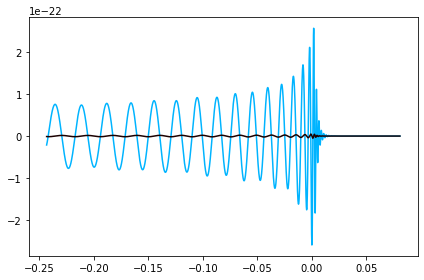

In [107]:
fdir = maya_catalog_info["cache_dir"]
file = f"{fdir}/data/{sim_name}.h5"

try:
    f.close()
except:
    pass

f = h5py.File(file, "a")

# Extrinsic parameters:
f_lower = 1
f_lower_at_1MSUN = f_lower / M
if "f_lower_at_1MSUN" not in list(f.attrs.keys()):
    f.attrs["f_lower_at_1MSUN"] = f_lower_at_1MSUN
    f.close()
else:
    f.close()

f = h5py.File(file, "r")
print(list(f.attrs.keys()))
# print(f.attrs.keys())
# print(f.keys())
params = {}


params["f_lower"] = f_lower
params["mtotal"] = M  # 150.0
params["inclination"] = inc  # 0.0
params["distance"] = D  # 100.0

# Metadata parameters:

params["eta"] = f.attrs["eta"]

params["mass1"] = pnutils.mtotal_eta_to_mass1_mass2(params["mtotal"], params["eta"])[0]
params["mass2"] = pnutils.mtotal_eta_to_mass1_mass2(params["mtotal"], params["eta"])[1]

# BH1 spins
params["spin1x"] = f.attrs["spin1x"]
params["spin1y"] = f.attrs["spin1y"]
params["spin1z"] = f.attrs["spin1z"]


# BH2 spins

params["spin2x"] = f.attrs["spin2x"]
params["spin2y"] = f.attrs["spin2y"]
params["spin2z"] = f.attrs["spin2z"]


# Spin unit vectors

params["nhat"] = [f.attrs["nhatx"], f.attrs["nhaty"], f.attrs["nhatz"]]
params["lnhat"] = [f.attrs["LNhatx"], f.attrs["LNhaty"], f.attrs["LNhatz"]]


# Check for coa_phase, else use the phase from nr cat load.
try:
    params["coa_phase"] = f.attrs["coa_phase"]
    raise Exception["NR coa phase is present!"]
except:
    print(f"Cannot find the attribute `coa_phase` in the file. Setting to {coa_phase}")
    # raise AttributeError('Cannot find the attribute `coa_phase` in the file')
    params["coa_phase"] = lal_coa_phase

# Transform spins

# NR frame
s1 = [params["spin1x"], params["spin1y"], params["spin1z"]]
s2 = [params["spin2x"], params["spin2y"], params["spin2z"]]

# LAL frame
from nrcatalogtools.lvc import transform_spins_nr_to_lal

S1, S2 = transform_spins_nr_to_lal(s1, s2, params["nhat"], params["lnhat"])

from pycbc.waveform import get_td_waveform


print("Loading waveform")
hp_l, hx_l = get_td_waveform(
    approximant="NR_hdf5",
    numrel_data=file,
    mass1=params["mass1"],
    mass2=params["mass2"],
    spin1x=S1[0],
    spin1y=S1[1],
    spin1z=S1[2],
    spin2x=S2[0],
    spin2y=S2[1],
    spin2z=S2[2],
    delta_t=delta_t,
    f_lower=f_lower,
    inclination=params["inclination"],
    coa_phase=params["coa_phase"],
    distance=params["distance"],
)

#
time_l = np.array(range(len(hp_l))) * delta_t
mtime = time_l[np.argmax(hp_l**2 + hx_l**2)]
time_l -= mtime
# pyplot.figure()
plt.plot(time_l, hp_l, color=[0, 0.7071, 1])
plt.plot(time_l, hx_l, color=[0.1, 0, 0])
plt.show()
f.close()

In [108]:
params

{'f_lower': 1,
 'mtotal': 40,
 'inclination': 1.5607963267948965,
 'distance': 1000,
 'eta': 0.25,
 'mass1': 20.0,
 'mass2': 20.0,
 'spin1x': 0.0,
 'spin1y': 0.0,
 'spin1z': 0.40003772,
 'spin2x': 0.0,
 'spin2y': 0.0,
 'spin2z': -0.40015087,
 'nhat': [-1.0, 0.0, 0.0],
 'lnhat': [0.0, 0.0, 1.0],
 'coa_phase': 2.104672196266241}

<a id='wftools_waveform'></a>
# Step 5. Method III: Generate waveform through waveformtools [Back to [top](#toc)\]




Waveforms are loaded using three interpolation methods:
1. 3rd order
2. 4th order
3. 5th order

$$\label{wftools_waveform}$$

## First, get rotation angles from nrcat

In [109]:
angles = mwf1.get_angles(inclination=inc, coa_phase=coa_phase)

In [110]:
angles

{'theta': 1.5607963267948965,
 'psi': 2.607716784118449,
 'alpha': 3.141592653589793,
 't_ref': -1,
 'f_ref': None}

## Second, load the waveforms using different interpolation methods using waveformtools.

In [111]:
# Path to modes data
# fdir = "/home/vprasad/.cache/MAYA/data/"
fdir = str(maya_catalog_info["data_dir"])
fname = f"{sim_name}.h5"

In [112]:
resam_type = "auto"

In [113]:
# Default 3rd order interp1d
wfm3 = modes_array(label="GT1 3", data_dir=fdir, file_name=fname)
# 4th order InterpolatedUnivariateSpline
wfm4 = modes_array(label="GT1 4", data_dir=fdir, file_name=fname)
# 5th order
wfm5 = modes_array(label="GT1 5", data_dir=fdir, file_name=fname)

In [114]:
wfm3.load_modes(
    ftype="GT", var_type="Strain", resam_type=resam_type, interp_kind="cubic"
)

Passing /home/prayush/.cache/MAYA/data/GT0356.h5
Loading RIT strain data.
Interpolating using interp1d
Fetching all keys from H5 file
['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'auxiliary-info', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2']
All files found ['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2']
ell_max not provided.
modes array not provided. Setting ell_max from file...
Chosen ell max 2 Available ell_max 2
Constructing the modes list
NRTimes not present. Will compute dt auto from mode time axis
Reading in modes...
Loading 2 -2
Creating modes data
Default dt is 0.15499999999997272


/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/site-packages/waveformtools/dataIO.py:709: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  dt_auto = mode(np.diff(time_axis))[0][0]


Sampling at the default timestep 0.15499999999997272
Loading 2 -1
Loading 2 0
Loading 2 1
Loading 2 2


1

In [115]:
wfm4.load_modes(ftype="GT", var_type="Strain", resam_type=resam_type, interp_kind=4)

Passing /home/prayush/.cache/MAYA/data/GT0356.h5
Loading RIT strain data.
Interpolating using InterpolatedUnivariateSpline
Fetching all keys from H5 file
['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'auxiliary-info', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2']
All files found ['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2']
ell_max not provided.
modes array not provided. Setting ell_max from file...
Chosen ell max 2 Available ell_max 2
Constructing the modes list
NRTimes not present. Will compute dt auto from mode time axis
Reading in modes...
Loading 2 -2
Creating modes data
Default dt is 0.15499999999997272
Sampling at the default timestep 0.15499999999997272
Loading 2 -1
Loading 2 0
Loading 2 1
Loading 2 2


1

In [116]:
wfm5.load_modes(ftype="GT", var_type="Strain", resam_type=resam_type, interp_kind=5)

Passing /home/prayush/.cache/MAYA/data/GT0356.h5
Loading RIT strain data.
Interpolating using InterpolatedUnivariateSpline
Fetching all keys from H5 file
['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'auxiliary-info', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2']
All files found ['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2']
ell_max not provided.
modes array not provided. Setting ell_max from file...
Chosen ell max 2 Available ell_max 2
Constructing the modes list
NRTimes not present. Will compute dt auto from mode time axis
Reading in modes...
Loading 2 -2
Creating modes data
Default dt is 0.15499999999997272
Sampling at the default timestep 0.15499999999997272
Loading 2 -1
Loading 2 0
Loading 2 1
Loading 2 2


1

In [117]:
wfm3.get_metadata()

{'label': 'GT1 3',
 'data_dir': '/home/prayush/.cache/MAYA/data',
 'file_name': 'GT0356.h5',
 'key_format': None,
 'ell_max': 2,
 'modes_list': [[2, [-2, -1, 0, 1, 2]]],
 'r_ext': inf,
 'frequency_axis': None,
 'out_file_name': None,
 'maxtime': None,
 'date': '2023-05-15',
 'time': '17:03:52',
 'key_ex': None,
 'spin_weight': -2,
 'actions': 'empty->load_modes->center'}

In [118]:
wfm3.delta_t()

0.775000000000091

## Generate the observer polarizations

In [127]:
%%time
# Using cubic interp1d
time_w3, hp_w3, hx_w3 = wfm3.to_td_waveform(
    Mtotal=M,
    distance=D,
    theta=angles["theta"],
    phi=angles["psi"],
    alpha=angles["alpha"],
    delta_t=delta_t,
    method="precise",
    k=None,
)

Using precise SWSH method
CPU times: user 1.61 s, sys: 5.46 ms, total: 1.62 s
Wall time: 1.62 s


In [128]:
mtime = time_w3[np.argmax(hp_w3**2 + hx_w3**2)]
time_w3 -= mtime

In [129]:
%%time
# Using InterpolatedUnivariateSpline order 4
time_w4, hp_w4, hx_w4 = wfm4.to_td_waveform(
    Mtotal=M,
    distance=D,
    theta=angles["theta"],
    phi=angles["psi"],
    alpha=angles["alpha"],
    delta_t=delta_t,
    method="precise",
    k=4,
)

Using precise SWSH method
Amplitude residue 0.0 	 Phase residue 0.0
CPU times: user 471 ms, sys: 3.7 ms, total: 474 ms
Wall time: 472 ms


In [130]:
mtime = time_w4[np.argmax(hp_w4**2 + hx_w4**2)]
time_w4 -= mtime

In [134]:
%%time
# Using InterpolatedUnivariateSpline order 5
time_w5, hp_w5, hx_w5 = wfm5.to_td_waveform(
    Mtotal=M,
    distance=D,
    theta=angles["theta"],
    phi=angles["psi"],
    alpha=angles["alpha"],
    delta_t=delta_t,
    method="precise",
    k=5,
)

Using precise SWSH method
Amplitude residue 0.0 	 Phase residue 0.0
CPU times: user 479 ms, sys: 0 ns, total: 479 ms
Wall time: 477 ms


In [132]:
mtime = time_w5[np.argmax(hp_w5**2 + hx_w5**2)]
time_w5 -= mtime

<a id='comparisons'></a>
# Step 6. Compare all waveform polarizations against lal and wftools [Back to [top](#toc)\]

Computed here are:
1. Deviations
1. Mismatches

Comparisons are made against lal and wftools 3rd, 4th and 5th order waveforms and also against each other.
$$\label{comparisons}$$

## Plain pol plots

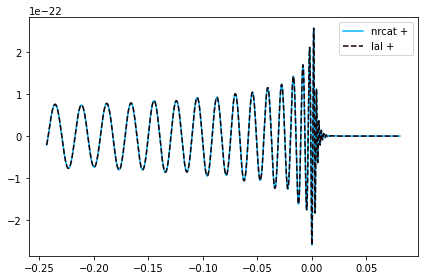

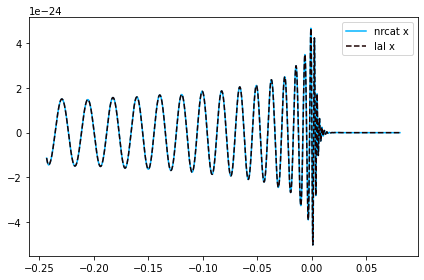

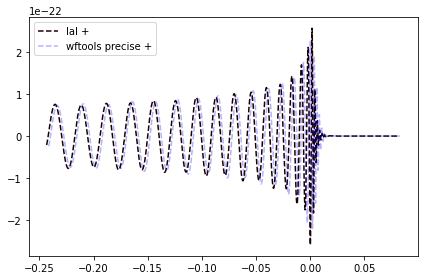

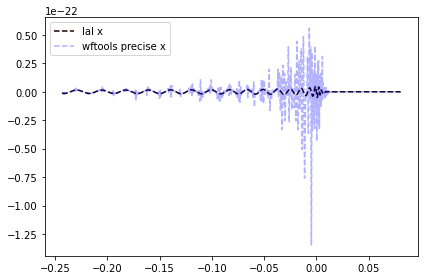

In [136]:
plt.plot(time_n, hp_n, color=[0, 0.7071, 1], label="nrcat +")
plt.plot(time_l, hp_l, color=[0.1, 0, 0], label="lal +", linestyle="--")
# plt.plot(time_w3, hp_w3, label='wftools +', c='blue', alpha=0.5, linestyle='--')
# plt.plot(time_w5, hp_w5, label='wftools +', c='blue', alpha=0.5, linestyle='--')
# plt.scatter(time, -hwx2, label='wftools fast', s=4, c='magenta')
# plt.plot(hc1.sample_times, hc1)
plt.legend()
plt.show()

plt.plot(time_n, hx_n, color=[0, 0.7071, 1], label="nrcat x")
plt.plot(time_l, hx_l, color=[0.1, 0, 0], label="lal x", linestyle="--")
# plt.plot(time_w3, hp_w3, label='wftools +', c='blue', alpha=0.5, linestyle='--')
# plt.plot(time_w5, hp_w5, label='wftools +', c='blue', alpha=0.5, linestyle='--')
# plt.scatter(time, -hwx2, label='wftools fast', s=4, c='magenta')
# plt.plot(hc1.sample_times, hc1)
plt.legend()
plt.show()

# plt.plot(time_n, hx_n, color=[0,0.7071,1], label='nrcat')
plt.plot(time_l, hp_l, color=[0.1, 0, 0], label="lal +", linestyle="--")
plt.plot(time_w3, hp_w3, label="wftools precise +", c="blue", alpha=0.3, linestyle="--")
# plt.scatter(time, -hwx2, label='wftools fast', s=4, c='magenta')
# plt.plot(hc1.sample_times, hc1)
plt.legend()
plt.show()

# plt.plot(time_n, hx_n, color=[0,0.7071,1], label='nrcat')
plt.plot(time_l, hx_l, color=[0.1, 0, 0], label="lal x", linestyle="--")
plt.plot(time_w5, hx_w5, label="wftools precise x", c="blue", alpha=0.3, linestyle="--")
# plt.scatter(time, -hwx2, label='wftools fast', s=4, c='magenta')
# plt.plot(hc1.sample_times, hc1)
plt.legend()
plt.show()

##  Convention

LAL  : $h_+ + i h_\times$

Nrcat : $h_+ - ih_\times$ 

Wftools : $h_+ + i h_\times$

## Amplitude, phase differences

The waveforms are compared by just aligning them in time.

The alignment is required for tracking differences in amplitudes and phases in time.

### Ensure that the maximum index of the arrays are same across different waveform.

In [138]:
wf_n = np.array(hp_n) + 1j * np.array(hx_n)
wf_l = np.array(hp_l) + 1j * np.array(hx_l)
wf_w3 = hp_w3 + 1j * hx_w3
wf_w4 = hp_w3 + 1j * hx_w4
wf_w5 = hp_w5 + 1j * hx_w5

norm_n = np.linalg.norm(wf_n)
norm_l = np.linalg.norm(wf_l)
norm_w3 = np.linalg.norm(wf_w3)
norm_w4 = np.linalg.norm(wf_w4)
norm_w5 = np.linalg.norm(wf_w5)

a_n, p_n = xtract_camp_phase(wf_n.real, wf_n.imag)
a_l, p_l = xtract_camp_phase(wf_l.real, wf_l.imag)
a_w3, p_w3 = xtract_camp_phase(wf_w3.real, wf_w3.imag)
a_w4, p_w4 = xtract_camp_phase(wf_w4.real, wf_w4.imag)
a_w5, p_w5 = xtract_camp_phase(wf_w5.real, wf_w5.imag)

imax_n, imax_l, imax_w3, imax_w4, imax_w5 = (
    np.argmax(a_n),
    np.argmax(a_l),
    np.argmax(a_w3),
    np.argmax(a_w4),
    np.argmax(a_w5),
)

print(imax_n, imax_l, imax_w3, imax_w4, imax_w5)

shift = imax_n - imax_w3
c = 0
if c < 1:
    a_w3 = roll(a_w3, shift)
    p_w3 = roll(p_w3, shift)
    c = 1

    c = 0
if c < 1:
    a_w4 = roll(a_w4, shift)
    p_w4 = roll(p_w4, shift)
    c = 1

c = 0
if c < 1:
    a_w5 = roll(a_w5, shift)
    p_w5 = roll(p_w5, shift)
    c = 1

imax_n, imax_l, imax_w3, imax_w4, imax_w5 = (
    np.argmax(a_n),
    np.argmax(a_l),
    np.argmax(a_w3),
    np.argmax(a_w4),
    np.argmax(a_w5),
)

print(imax_n, imax_l, imax_w3, imax_w4, imax_w5)

t_l = np.array(time_l - time_l[imax_l])
t_n = np.array(time_n - time_n[imax_n])
t_w3 = np.array(time_w3 - time_w3[imax_w3])
t_w4 = np.array(time_w4 - time_w4[imax_w4])
t_w5 = np.array(time_w5 - time_w5[imax_w5])

3986 3986 3954 3954 3954
3986 3986 3986 3986 3986


### Norms

In [139]:
norm_l, norm_n, norm_w3, norm_w4, norm_w5

(4.651000171172666e-21,
 4.651000152931505e-21,
 4.612096058282922e-21,
 4.625079112959761e-21,
 4.612404722671811e-21)

In [140]:
hp_w3_r = TimeSeries(a_w3 * np.cos(p_w3), delta_t)
hx_w3_r = TimeSeries(a_w3 * np.sin(p_w3), delta_t)

hp_w4_r = TimeSeries(a_w4 * np.cos(p_w4), delta_t)
hx_w4_r = TimeSeries(a_w4 * np.sin(p_w4), delta_t)

hp_w5_r = TimeSeries(a_w5 * np.cos(p_w5), delta_t)
hx_w5_r = TimeSeries(a_w5 * np.sin(p_w5), delta_t)

<a id='mismatch'></a>
## Step 6.1: Mismatches [Back to [top](#toc)\]

$$\label{mismatch}$$

In [141]:
mp_nl = match(hp_n, hp_l)[0]
mx_nl = match(hx_n, hx_l)[0]
m_nl = min(mp_nl, mx_nl)
mm_nl = 100 * (1 - m_nl)

mp_w3l = match(hp_w3_r, hp_l)[0]
mx_w3l = match(hx_w3_r, hx_l)[0]
m_w3l = min(mp_w3l, mx_w3l)
mm_w3l = 100 * (1 - m_w3l)

mp_w4l = match(hp_w4_r, hp_l)[0]
mx_w4l = match(hx_w4_r, hp_l)[0]
m_w4l = min(mp_w4l, mx_w4l)
mm_w4l = 100 * (1 - m_w4l)

mp_w5l = match(hp_w5_r, hp_l)[0]
mx_w5l = match(hx_w5_r, hp_l)[0]
m_w5l = min(mp_w5l, mx_w5l)
mm_w5l = 100 * (1 - m_w5l)

mp_w3n = match(hp_w3_r, hp_n)[0]
mx_w3n = match(hx_w3_r, hp_n)[0]
m_w3n = min(mp_w3n, mx_w3n)
mm_w3n = 100 * (1 - m_w3n)

mp_w4n = match(hp_w4_r, hp_n)[0]
mx_w4n = match(hx_w4_r, hp_n)[0]
m_w4n = min(mp_w4n, mx_w4n)
mm_w4n = 100 * (1 - m_w4n)

mp_w5n = match(hp_w5_r, hp_n)[0]
mx_w5n = match(hx_w5_r, hp_n)[0]
m_w5n = min(mp_w5n, mx_w5n)
mm_w5n = 100 * (1 - m_w5n)

In [142]:
m_nl, m_w3l, m_w4l, m_w5l

(0.9999999999958649,
 0.30494275027765,
 0.27281192221593853,
 0.25123427752121963)

In [143]:
pol_mismatches = {
    "n-l": mm_nl,
    "w3-l": mm_w3l,
    "w4-l": mm_w4l,
    "w5-l": mm_w5l,
    "w3-n": mm_w3n,
    "w4-n": mm_w4n,
    "w5-n": mm_w5n,
}

### waveformtools vs lal

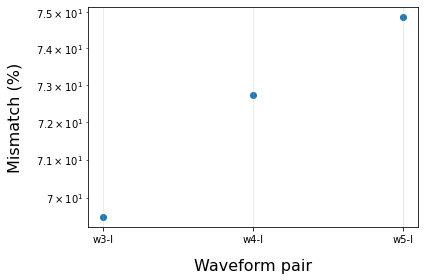

In [144]:
keys = ["w3-l", "w4-l", "w5-l"]
vals = [pol_mismatches[key] for key in keys]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.scatter(keys, vals)
ax.set_xlabel("Waveform pair")
ax.set_ylabel("Mismatch (%)")
plt.grid()
plt.show()

In [145]:
m_nl, m_w3l, m_w4l, m_w5l

(0.9999999999958649,
 0.30494275027765,
 0.27281192221593853,
 0.25123427752121963)

### waveformtools vs nrcat

In [146]:
mc.get_metadata("GT0356")

Metadata([('GTID', 'GT0356'),
          ('GT_Tag', 'D11_a0.4_q1.00_m103_As'),
          ('q', 1.0),
          ('a1x', 0.0),
          ('a1y', 0.0),
          ('a1z', 0.4),
          ('a2x', 0.0),
          ('a2y', 0.0),
          ('a2z', -0.4002),
          ('af', 0.6857),
          ('mf', 0.9514),
          ('Momega', 0.02513),
          ('metadata_location',
           '/home/prayush/.cache/MAYA/metadata/GT0356.txt'),
          ('metadata_link',
           'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/catalog-table.txt'),
          ('waveform_data_link',
           'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files/GT0356.h5'),
          ('waveform_data_location',
           '/home/prayush/.cache/MAYA/data/GT0356.h5')])

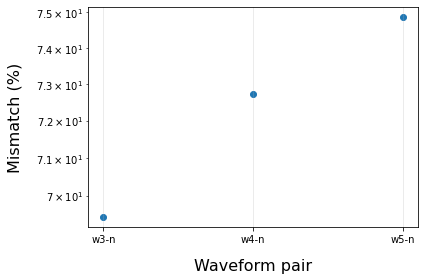

In [147]:
keys = ["w3-n", "w4-n", "w5-n"]
vals = [pol_mismatches[key] for key in keys]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.scatter(keys, vals)
ax.set_xlabel("Waveform pair")
ax.set_ylabel("Mismatch (%)")
plt.grid()
plt.show()

### All vs lal

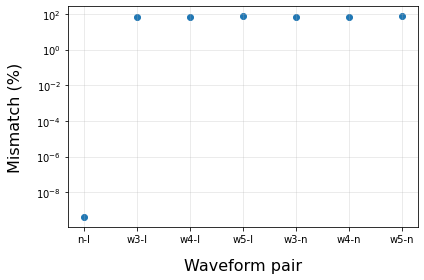

In [148]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.scatter(pol_mismatches.keys(), pol_mismatches.values())
ax.set_xlabel("Waveform pair")
ax.set_ylabel("Mismatch (%)")
plt.grid()
plt.show()

<a id='pointwise'></a>
## Step 6.2: Pointwise deviations [Back to [top](#toc)\]

$$\label{pointwise}$$

### Extract amplitude and phase deviations

In [149]:
ratio_nl = wf_n / wf_l

ratio_w3l = wf_w3 / wf_l
ratio_w4l = wf_w4 / wf_l
ratio_w5l = wf_w5 / wf_l


ratio_w3n = wf_w3 / wf_n
ratio_w4n = wf_w4 / wf_n
ratio_w5n = wf_w5 / wf_n


amp_nl = np.absolute(ratio_nl) - 1

amp_w3l = np.absolute(ratio_w3l) - 1
amp_w4l = np.absolute(ratio_w4l) - 1
amp_w5l = np.absolute(ratio_w5l) - 1

amp_w3n = np.absolute(ratio_w3n) - 1
amp_w4n = np.absolute(ratio_w4n) - 1
amp_w5n = np.absolute(ratio_w5n) - 1


phase_nl = np.unwrap(np.angle(ratio_nl))

phase_w3l = np.unwrap(np.angle(ratio_w3l))
phase_w4l = np.unwrap(np.angle(ratio_w4l))
phase_w5l = np.unwrap(np.angle(ratio_w5l))

phase_w3n = np.unwrap(np.angle(ratio_w3n))
phase_w4n = np.unwrap(np.angle(ratio_w4n))
phase_w5n = np.unwrap(np.angle(ratio_w5n))

### Common time axis

In [150]:
# All time axes are the same.
ctime = t_l

### nrcat vs lal

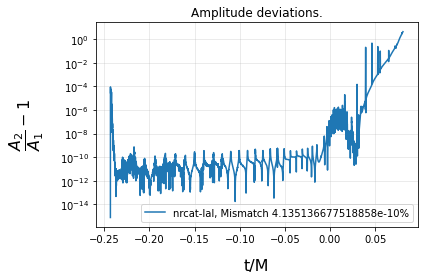

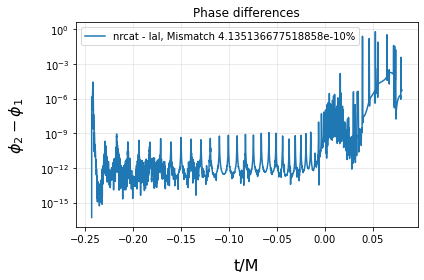

In [151]:
fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(amp_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(ctime, np.absolute(amp_nl), label=f"nrcat-lal, Mismatch {mm_nl}%")
# ax.plot(ctime, np.absolute(amp_w4n), label=f'wftools4 - nrcat, Mismatch {round(mm_w4n, 5)}%', alpha=0.7)
# ax.plot(ctime, np.absolute(amp_w5n), label=f'wftools5 - nrcat, Mismatch {round(mm_w5n, 5)}%', linestyle='--')
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.xlabel("t/M")
plt.ylabel(r"$\dfrac{A_2}{A_1} -1 $")
plt.title(f"Amplitude deviations.")
plt.legend()
plt.grid()
# plt.savefig('pol_amp_deviation_resampled_5.png')
plt.show()


fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(phase_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(ctime, np.absolute(phase_nl), label=f"nrcat - lal, Mismatch {mm_nl}%")
# ax.plot(ctime, np.absolute(phase_w4n), label=f'wftools4 - lal, Mismatch {round(mm_w4n, 5)}%')
# ax.plot(ctime, np.absolute(phase_w5n), label=f'wftools5 - lal, Mismatch {round(mm_w5n, 5)}%')
plt.xlabel("t/M")
plt.ylabel(r"$\phi_2 - \phi_1$")
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.title("Phase differences")
plt.legend()
plt.grid()
# plt.savefig('pol_phase_diff_resampled_5.png')
plt.show()

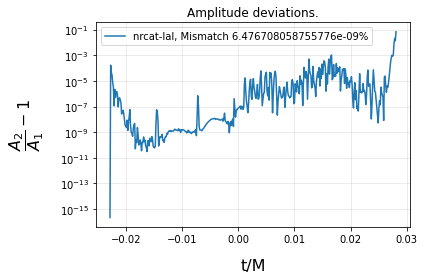

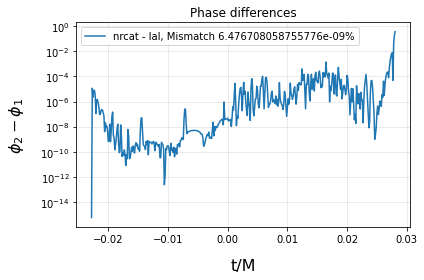

In [135]:
fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(amp_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(ctime, np.absolute(amp_nl), label=f"nrcat-lal, Mismatch {mm_nl}%")
# ax.plot(ctime, np.absolute(amp_w4n), label=f'wftools4 - nrcat, Mismatch {round(mm_w4n, 5)}%', alpha=0.7)
# ax.plot(ctime, np.absolute(amp_w5n), label=f'wftools5 - nrcat, Mismatch {round(mm_w5n, 5)}%', linestyle='--')
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.xlabel("t/M")
plt.ylabel(r"$\dfrac{A_2}{A_1} -1 $")
plt.title(f"Amplitude deviations.")
plt.legend()
plt.grid()
# plt.savefig('pol_amp_deviation_resampled_5.png')
plt.show()


fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(phase_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(ctime, np.absolute(phase_nl), label=f"nrcat - lal, Mismatch {mm_nl}%")
# ax.plot(ctime, np.absolute(phase_w4n), label=f'wftools4 - lal, Mismatch {round(mm_w4n, 5)}%')
# ax.plot(ctime, np.absolute(phase_w5n), label=f'wftools5 - lal, Mismatch {round(mm_w5n, 5)}%')
plt.xlabel("t/M")
plt.ylabel(r"$\phi_2 - \phi_1$")
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.title("Phase differences")
plt.legend()
plt.grid()
# plt.savefig('pol_phase_diff_resampled_5.png')
plt.show()

### lal vs waveformtools

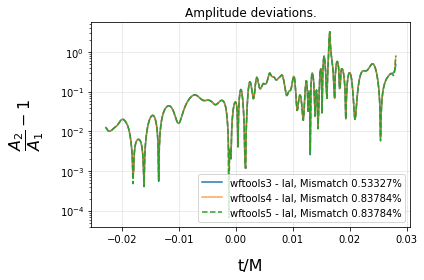

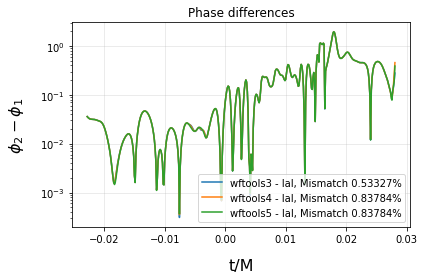

In [136]:
fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(amp_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(
    ctime, np.absolute(amp_w3l), label=f"wftools3 - lal, Mismatch {round(mm_w3l, 5)}%"
)
ax.plot(
    ctime,
    np.absolute(amp_w4l),
    label=f"wftools4 - lal, Mismatch {round(mm_w4l, 5)}%",
    alpha=0.7,
)
ax.plot(
    ctime,
    np.absolute(amp_w5l),
    label=f"wftools5 - lal, Mismatch {round(mm_w5l, 5)}%",
    linestyle="--",
)
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.xlabel("t/M")
plt.ylabel(r"$\dfrac{A_2}{A_1} -1 $")
plt.title(f"Amplitude deviations.")
plt.legend()
plt.grid()
# plt.savefig('pol_amp_deviation_resampled_5.png')
plt.show()


fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(phase_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(
    ctime, np.absolute(phase_w3l), label=f"wftools3 - lal, Mismatch {round(mm_w3l, 5)}%"
)
ax.plot(
    ctime, np.absolute(phase_w4l), label=f"wftools4 - lal, Mismatch {round(mm_w4l, 5)}%"
)
ax.plot(
    ctime, np.absolute(phase_w5l), label=f"wftools5 - lal, Mismatch {round(mm_w5l, 5)}%"
)
plt.xlabel("t/M")
plt.ylabel(r"$\phi_2 - \phi_1$")
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.title("Phase differences")
plt.legend()
plt.grid()
# plt.savefig('pol_phase_diff_resampled_5.png')
plt.show()

### nrcat vs waveformtools

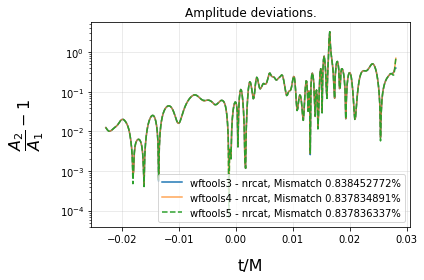

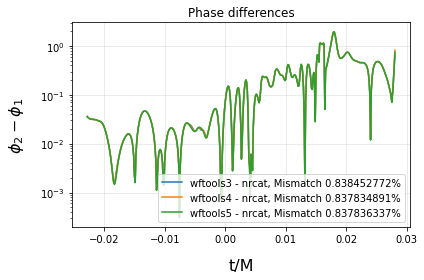

In [142]:
fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(amp_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(
    ctime, np.absolute(amp_w3n), label=f"wftools3 - nrcat, Mismatch {round(mm_w3n, 9)}%"
)
ax.plot(
    ctime,
    np.absolute(amp_w4n),
    label=f"wftools4 - nrcat, Mismatch {round(mm_w4n, 9)}%",
    alpha=0.7,
)
ax.plot(
    ctime,
    np.absolute(amp_w5n),
    label=f"wftools5 - nrcat, Mismatch {round(mm_w5n, 9)}%",
    linestyle="--",
)
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.xlabel("t/M")
plt.ylabel(r"$\dfrac{A_2}{A_1} -1 $")
plt.title(f"Amplitude deviations.")
plt.legend()
plt.grid()
# plt.savefig('pol_amp_deviation_resampled_5.png')
plt.show()


fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(ctime, np.absolute(phase_10_ca), label=f'nrcat - lal, Mismatch {round(m10_ca, 5)}%')
ax.plot(
    ctime,
    np.absolute(phase_w3n),
    label=f"wftools3 - nrcat, Mismatch {round(mm_w3n, 9)}%",
)
ax.plot(
    ctime,
    np.absolute(phase_w4n),
    label=f"wftools4 - nrcat, Mismatch {round(mm_w4n, 9)}%",
)
ax.plot(
    ctime,
    np.absolute(phase_w5n),
    label=f"wftools5 - nrcat, Mismatch {round(mm_w5n, 9)}%",
)
plt.xlabel("t/M")
plt.ylabel(r"$\phi_2 - \phi_1$")
# plt.plot(ctime, mode_22_lal_rs.real, label='lal')
plt.title("Phase differences")
plt.legend()
plt.grid()
# plt.savefig('pol_phase_diff_resampled_5.png')
plt.show()

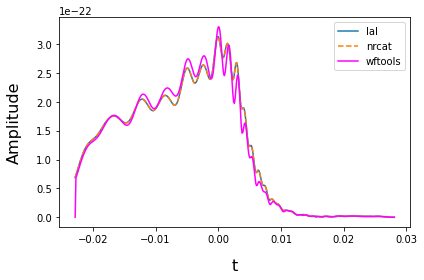

In [137]:
plt.plot(t_l, a_l, label="lal")
plt.plot(t_n, a_n, label="nrcat", linestyle="--")
plt.plot(t_w3, a_w3, label="wftools", c="magenta")
plt.xlabel("t")
plt.ylabel("Amplitude")
# plt.plot(hc1.sample_times, hc1)
plt.legend()
plt.show()

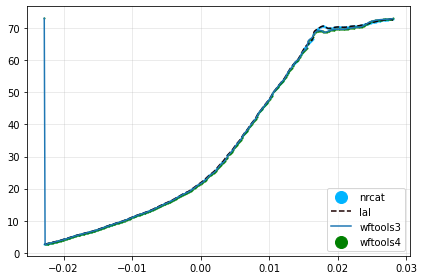

In [140]:
fig, ax = plt.subplots()
# ax.set_yscale('log')

plt.scatter(ctime, p_l, color=[0, 0.7071, 1], label="nrcat", s=1)
plt.plot(ctime, p_n, color=[0.1, 0, 0], label="lal", linestyle="--")
plt.plot(ctime, p_w3, label="wftools3")
plt.title("Phase")
plt.scatter(ctime, p_w4, label="wftools4", s=1, c="green")
plt.grid()
# plt.scatter(time, np.absolute(dwf_132), label='nrcat - wftools fast', s=1, c='orange')
# plt.plot(hc1.sample_times, hc1)
plt.legend()
plt.show()